# Multi Logistic Regression Analysis
Video can be found at: https://www.youtube.com/watch?v=zM4VZR0px8E

## Import our Libraries
The first thing we need to do is import the libraries we will be using in this tutorial. To visualize our data, we will be using matplotlib and seaborn to create heatmaps and a scatter matrix. To build our model, we will be using the sklearn library, and the evaluation will be taking place with the statsmodels library. I've also added a few additional modules to help calculate certain metrics.

## Load and Format Data

In [156]:
#import packages
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import linregress

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [169]:
#load team data
game_data = pd.read_csv('gamelog_adv.csv')
game_data.head()

,Team,Conference,Division,Game Number in The Season,Season,Date,Home or Away,Opponent,GF,GA,...,CF%,FF,FA,FF%,FOW,FOL,FO%,oZS%,PDO,Blocked Shots
0,WSH,Eastern,Metropolitan,1,2018-19,10/3/2018,Home,Boston Bruins,7,0,...,47.7,31,31,50.0,16,32,33.3,60.7,113.0,14
1,WSH,Eastern,Metropolitan,2,2018-19,10/4/2018,Away,Pittsburgh Penguins,6,7,...,43.4,36,47,43.4,26,30,46.4,60.7,105.7,13
2,WSH,Eastern,Metropolitan,3,2018-19,10/10/2018,Home,Vegas Golden Knights,5,2,...,40.6,34,41,45.3,26,30,46.4,40.5,105.4,19
3,WSH,Eastern,Metropolitan,4,2018-19,10/11/2018,Away,New Jersey Devils,0,6,...,43.4,26,48,35.1,18,31,36.7,45.7,84.8,8
4,WSH,Eastern,Metropolitan,5,2018-19,10/13/2018,Home,Toronto Maple Leafs,2,4,...,50.5,33,32,50.8,19,19,50.0,47.6,90.9,16


In [170]:
#change game outcome to 0 or 1
game_data['Win or Loss'] = game_data['Win or Loss'].map({'W': 1, 'L': 0})
game_data.head()

,Team,Conference,Division,Game Number in The Season,Season,Date,Home or Away,Opponent,GF,GA,...,CF%,FF,FA,FF%,FOW,FOL,FO%,oZS%,PDO,Blocked Shots
0,WSH,Eastern,Metropolitan,1,2018-19,10/3/2018,Home,Boston Bruins,7,0,...,47.7,31,31,50.0,16,32,33.3,60.7,113.0,14
1,WSH,Eastern,Metropolitan,2,2018-19,10/4/2018,Away,Pittsburgh Penguins,6,7,...,43.4,36,47,43.4,26,30,46.4,60.7,105.7,13
2,WSH,Eastern,Metropolitan,3,2018-19,10/10/2018,Home,Vegas Golden Knights,5,2,...,40.6,34,41,45.3,26,30,46.4,40.5,105.4,19
3,WSH,Eastern,Metropolitan,4,2018-19,10/11/2018,Away,New Jersey Devils,0,6,...,43.4,26,48,35.1,18,31,36.7,45.7,84.8,8
4,WSH,Eastern,Metropolitan,5,2018-19,10/13/2018,Home,Toronto Maple Leafs,2,4,...,50.5,33,32,50.8,19,19,50.0,47.6,90.9,16


In [171]:
#remove variables won't be used or that will have high multicolinearity 
game_data = game_data.drop(['Team','Conference ', 'Division', 'Game Number in The Season', 'Season', 'Date',
                            'Home or Away','Opponent','GF','GA','PPO','PPG','PPG Against','SHG','SHG Against',
                           'FOW','FOL','CF','CA','FF','FA','Overtime Status (OT or SO)','Final Result'], axis = 1)

game_data.head()

,Win or Loss,S,PIM,PP%,Shots Against,Penalty Minutes by Opponent,PPO Against,PK%,CF%,FF%,FO%,oZS%,PDO,Blocked Shots
0,1,37,14,67%,25,32,2,100.00%,47.7,50.0,33.3,60.7,113.0,14
1,0,36,12,0%,41,4,6,66.67%,43.4,43.4,46.4,60.7,105.7,13
2,1,29,6,50%,31,8,3,100.00%,40.6,45.3,46.4,40.5,105.4,19
3,0,21,10,0%,36,10,4,75.00%,43.4,35.1,36.7,45.7,84.8,8
4,0,27,6,33%,28,6,3,66.67%,50.5,50.8,50.0,47.6,90.9,16


In [172]:
#Turn %'s to actual numbers
game_data['PP%'] = game_data['PP%'].str.replace('%','')
game_data['PP%'] = game_data['PP%'].astype(float)

game_data['PK%'] = game_data['PK%'].str.replace('%','')
game_data['PK%'] = game_data['PK%'].astype(float)

In [173]:
# make sure columns are floats
game_data = game_data.astype(float)
game_data.head()

,Win or Loss,S,PIM,PP%,Shots Against,Penalty Minutes by Opponent,PPO Against,PK%,CF%,FF%,FO%,oZS%,PDO,Blocked Shots
0,1.0,37.0,14.0,67.0,25.0,32.0,2.0,100.00,47.7,50.0,33.3,60.7,113.0,14.0
1,0.0,36.0,12.0,0.0,41.0,4.0,6.0,66.67,43.4,43.4,46.4,60.7,105.7,13.0
2,1.0,29.0,6.0,50.0,31.0,8.0,3.0,100.00,40.6,45.3,46.4,40.5,105.4,19.0
3,0.0,21.0,10.0,0.0,36.0,10.0,4.0,75.00,43.4,35.1,36.7,45.7,84.8,8.0
4,0.0,27.0,6.0,33.0,28.0,6.0,3.0,66.67,50.5,50.8,50.0,47.6,90.9,16.0


In [174]:
desc_df = game_data.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

desc_df

,Win or Loss,S,PIM,PP%,Shots Against,Penalty Minutes by Opponent,PPO Against,PK%,CF%,FF%,FO%,oZS%,PDO,Blocked Shots
count,7544.000000,7544.000000,7544.000000,7386.000000,7544.000000,7544.000000,7544.000000,7386.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000
mean,0.500000,31.216198,8.572773,19.723125,31.216198,8.572773,2.982105,80.254815,50.000676,50.000835,50.000451,50.001246,100.000530,12.246554
std,0.500033,6.706755,6.379405,26.219310,6.706755,6.374790,1.467243,26.223449,7.789080,8.073554,7.785277,11.403105,9.322139,4.494217
min,0.000000,12.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,23.200000,21.600000,15.000000,12.000000,61.500000,0.000000
25%,0.000000,26.000000,4.000000,0.000000,26.000000,4.000000,2.000000,66.670000,44.700000,44.300000,44.700000,42.100000,93.500000,9.000000
50%,0.500000,31.000000,8.000000,0.000000,31.000000,8.000000,3.000000,100.000000,50.000000,50.000000,50.000000,50.000000,100.000000,12.000000
75%,1.000000,36.000000,10.000000,33.000000,36.000000,10.000000,4.000000,100.000000,55.300000,55.700000,55.300000,57.900000,106.500000,15.000000
max,1.000000,60.000000,96.000000,100.000000,60.000000,96.000000,10.000000,100.000000,76.800000,78.400000,85.000000,88.000000,138.500000,32.000000
+3_std,2.000099,51.336463,27.710989,98.381056,51.336463,27.697143,7.383834,158.925163,73.367917,74.221497,73.356281,84.210562,127.966946,25.729204
-3_std,-1.000099,11.095933,-10.565443,-58.934806,11.095933,-10.551597,-1.419624,1.584466,26.633435,25.780173,26.644620,15.791930,72.034114,-1.236097


In [175]:
#remove na's, infinite values
game_data_clean = game_data[~game_data.isin([np.nan, np.inf, -np.inf]).any(1)]
#how many rows did we remove?
len(game_data)-len(game_data_clean)

304

In [176]:
# filter the data frame to remove the values exceeding 3 standard deviations (outliers)
game_remove_data = game_data_clean[(np.abs(stats.zscore(game_data_clean)) < 3).all(axis=1)]
#how many outliers did we remove?
len(game_data)-len(game_remove_data)

1218

## Check for Multicolinearity
Multicollinearity is where one of the explanatory variables is highly correlated with another explanatory variable. This can make the coefficient (slope) estimates unreliable. 

,Win or Loss,S,PIM,PP%,Shots Against,Penalty Minutes by Opponent,PPO Against,PK%,CF%,FF%,FO%,oZS%,PDO,Blocked Shots
Win or Loss,1.000000,0.007447,-0.016883,0.199136,-0.009158,0.022000,-0.006511,0.199904,-0.159131,-0.054520,0.018482,-0.233690,0.719171,0.190862
S,0.007447,1.000000,-0.071042,0.045304,-0.132544,0.103521,-0.100105,-0.043392,0.561358,0.612801,0.095990,0.358233,-0.187451,-0.121951
PIM,-0.016883,-0.071042,1.000000,0.043647,0.100781,0.590012,0.627241,-0.147928,-0.033624,-0.029449,-0.004611,-0.022472,0.037733,-0.100803
PP%,0.199136,0.045304,0.043647,1.000000,0.042973,0.149148,0.043236,-0.015625,-0.090507,-0.070563,-0.024875,-0.056725,0.008777,0.051839
Shots Against,-0.009158,-0.132544,0.100781,0.042973,1.000000,-0.070210,0.166898,-0.044866,-0.560466,-0.613693,-0.094939,-0.357347,0.185624,0.165109
Penalty Minutes by Opponent,0.022000,0.103521,0.590012,0.149148,-0.070210,1.000000,0.158071,-0.044358,0.029679,0.028513,0.006566,0.018217,-0.036324,-0.131989
PPO Against,-0.006511,-0.100105,0.627241,0.043236,0.166898,0.158071,1.000000,-0.194654,-0.055579,-0.045851,-0.012777,-0.035001,0.082265,-0.105031
PK%,0.199904,-0.043392,-0.147928,-0.015625,-0.044866,-0.044358,-0.194654,1.000000,-0.090194,-0.069689,-0.021926,-0.055843,0.008525,0.061113
CF%,-0.159131,0.561358,-0.033624,-0.090507,-0.560466,0.029679,-0.055579,-0.090194,1.000000,0.916222,0.151985,0.577999,-0.344898,-0.478809
FF%,-0.054520,0.612801,-0.029449,-0.070563,-0.613693,0.028513,-0.045851,-0.069689,0.916222,1.000000,0.145799,0.523040,-0.268748,-0.237577


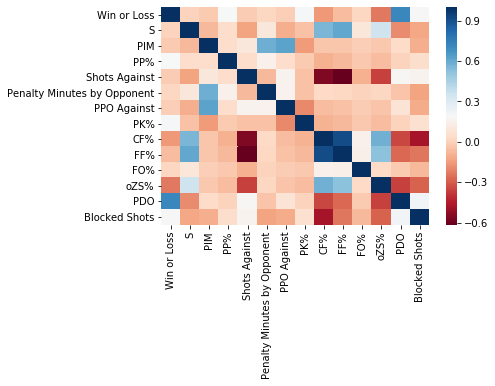

In [177]:
# to avoid multicolinearity we check the correlation between all vaiables
# calculate the correlation matrix
corr = game_remove_data.corr()

# display the correlation matrix
display(corr)

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

<font color='red'>**Variables close to 1 and -1 should be removed** </font>

In [179]:
#remove FF% - too much correlation with CF%
game_data_final = game_remove_data.drop(['FF%'], axis = 1)
game_data_final.head()

,Win or Loss,S,PIM,PP%,Shots Against,Penalty Minutes by Opponent,PPO Against,PK%,CF%,FO%,oZS%,PDO,Blocked Shots
1,0.0,36.0,12.0,0.0,41.0,4.0,6.0,66.67,43.4,46.4,60.7,105.7,13.0
2,1.0,29.0,6.0,50.0,31.0,8.0,3.0,100.00,40.6,46.4,40.5,105.4,19.0
3,0.0,21.0,10.0,0.0,36.0,10.0,4.0,75.00,43.4,36.7,45.7,84.8,8.0
4,0.0,27.0,6.0,33.0,28.0,6.0,3.0,66.67,50.5,50.0,47.6,90.9,16.0
5,1.0,38.0,8.0,50.0,32.0,8.0,4.0,50.00,54.8,51.0,58.2,103.1,7.0


## Build the Model
The first thing we need to do is, define our exploratory variables and our explanatory variable. From here, let's split the data into a training and testing set; a healthy ratio is 20% testing and 80% training but a 30% 70% split is also ok.

After splitting the data, we will create an instance of the linear regression model and pass through the X_train and y_train variables using the fit() function.

In [182]:
# define our input variable (X) & output variable (Y)
# input contains explanatory variables and output contains goals against (GA)
X = game_data_final.drop('Win or Loss', axis = 1)
Y = game_data_final[['Win or Loss']]

# Split X and y into X_
#20% of data will be use for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [183]:
# create a Logistic Regression model object
model = LogisticRegression()

# pass through the X_train & y_train data set
model.fit(X_train, y_train.values.ravel())

#to predict values
#model.predict(X_test)

C:\Users\jvanzalk\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [184]:
#get summary of model with p-values,coefficients,r-squared
# create a OLS model
model = sm.Logit(y_train,X_train)

# fit the data
est = model.fit()

print(est.summary())

Optimization terminated successfully.
         Current function value: 0.371853
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            Win or Loss   No. Observations:                 5060
Model:                          Logit   Df Residuals:                     5048
Method:                           MLE   Df Model:                           11
Date:                Thu, 31 Oct 2019   Pseudo R-squ.:                  0.4634
Time:                        13:47:14   Log-Likelihood:                -1881.6
converged:                       True   LL-Null:                       -3506.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
S                               0.1607      0.009     17.782      0.000   

In [209]:
# interpret the coefficients
#get pvalues
df = pd.DataFrame(est.pvalues)
df = df.reset_index()
df.rename(columns={0:'pvalue'},inplace=True)

#get coeffs and merge
df2 = pd.DataFrame(est.params.values)
df2.rename(columns={0:'coeff'},inplace=True)
df= df.join(df2, how='outer')
df

,index,pvalue,coeff
0,S,9.711026e-71,0.160693
1,PIM,5.447291e-03,0.041643
2,PP%,6.746036e-49,0.031437
3,Shots Against,9.497833e-187,-0.271226
4,Penalty Minutes by Opponent,6.135346e-10,-0.076601
5,PPO Against,3.986959e-04,-0.151464
6,PK%,4.142595e-12,0.013361
7,CF%,1.563593e-126,-0.234543
8,FO%,2.019442e-19,-0.048164
9,oZS%,2.639213e-33,-0.055674


In [215]:
# exponate coeff to allow for easier interpretation
df['exp'] = (np.exp(df['coeff'])-1)*100
df= df.sort_values('exp', ascending=False)
df

,index,pvalue,coeff,exp
10,PDO,4.772715e-252,0.213277,23.772698
0,S,9.711026e-71,0.160693,17.432494
1,PIM,5.447291e-03,0.041643,4.252244
2,PP%,6.746036e-49,0.031437,3.193591
6,PK%,4.142595e-12,0.013361,1.345075
8,FO%,2.019442e-19,-0.048164,-4.702249
9,oZS%,2.639213e-33,-0.055674,-5.415297
4,Penalty Minutes by Opponent,6.135346e-10,-0.076601,-7.374051
11,Blocked Shots,1.765550e-37,-0.144157,-13.424791
5,PPO Against,3.986959e-04,-0.151464,-14.055083


# Interpretation
We found significant relationships with all varibales in our model. All relationships are weak (coefficients less than 0.3). We have a small R2 (our model predicts only 46% of variability). This makes sense. If we think about all the things that might affect the outcome of a game, the factors that we've included could only paritally explain the outcome. 

